In [1]:
import torch
from z3 import *
from helpers import *
from toolz.curried import *
from model import *
import altair as alt
import pandas as pd
from interpretation import tools, parmap, to_clause, Clause, load_model, MLP_hidden_contributions
import itertools
from sympy import symbols, Rational, integrate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree, metrics
import sklearn
import graphviz
from math import ceil
from sklearn.tree import _tree
from collections import defaultdict
import dill as pickle
from subprocess import run

In [2]:
device = torch.device("cuda") if torch.backends.cuda.is_built() else torch.device("cpu")

In [3]:
config = Config(
    load_model_path="models/layers_2_heads_1_4_1M/900.pth",
    data_path="data/cnf_tokens_1M.npy",
    data_path_interpretation = "data/cnf_tokens_100K.npy",
    base_cache_path="cache",
    num_heads=[1,4],
    batch_size=100,
    device=device,
    data_parallel=False,
)

See `interpretation.py` for the details, including the alphas, gammas, model decomposition, and abstract model definition.

In [4]:
interp_tools = tools(config)

def to_globals(d):
    for k, v in d.items():
        globals()[k] = v

# See interpretation.py for the functions/data made available
to_globals(interp_tools.__dict__)

SAT instances in fixed len data:  100001
UNSAT instances in fixed len data:  100000
SAT instances in train:  60000
UNSAT instances in train:  60000
SAT instances in test:  40001
UNSAT instances in test:  40000


# First-layer attentions:

## Example Attentions

In [5]:
def save_chart(chart, name):
    name = name.split(".")[0]
    json_name = name + ".json"
    pdf_name = name + ".pdf"
    chart.save(json_name)
    run(["vl2pdf", json_name, pdf_name])
    os.remove(json_name)
    return chart

os.makedirs("img", exist_ok=True)

In [6]:
sample = test[0]
toks = [rev_token_mappings[t] for t in sample]
helpers.decode_to_CNFs(sample, config)

'( Not(x0) Not(x1) ) ( x1 Not(x4) ) ( x1 x2 ) ( x0 x3 ) ( Not(x2) Not(x3) ) ( x2 Not(x4) ) ( Not(x0) Not(x3) ) ( x0 x2 ) ( x1 Not(x2) ) ( x1 x4 ) : u'

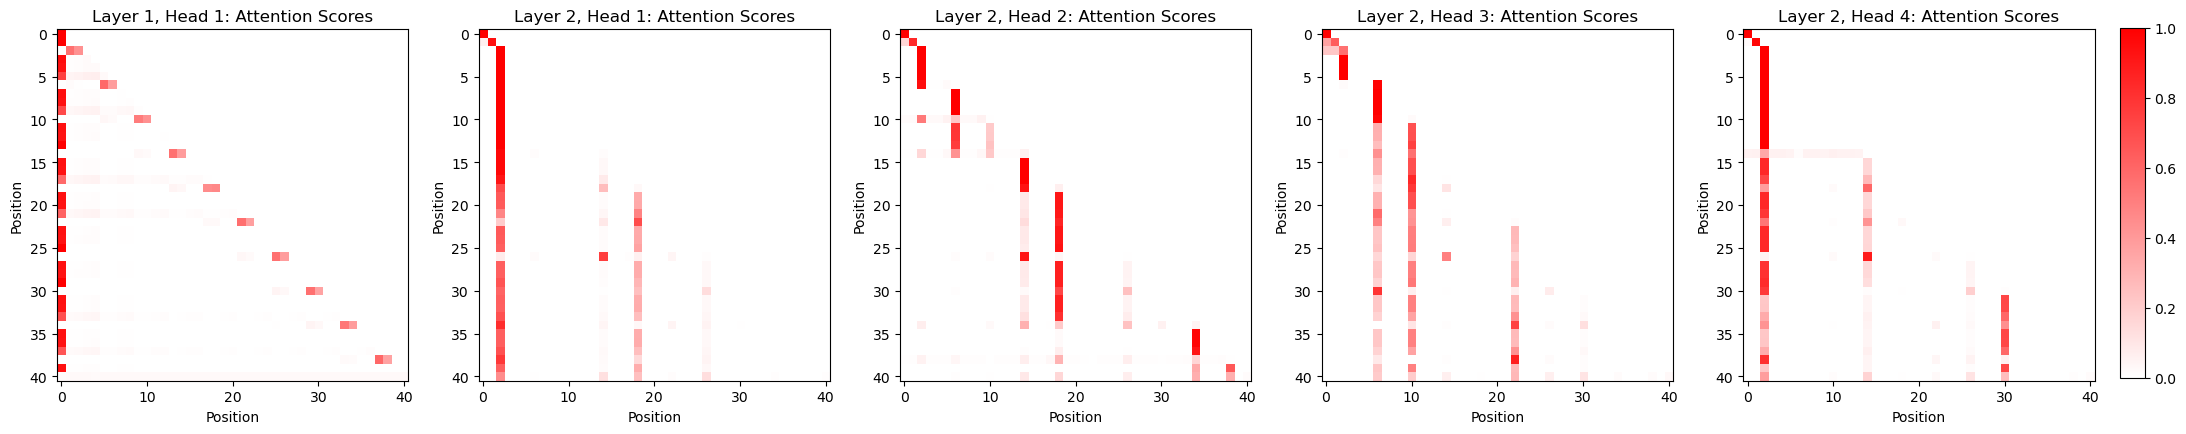

In [7]:
plot_attentions(sample)
plt.savefig("img/attns_sample.pdf", bbox_inches="tight")

## All Attentions

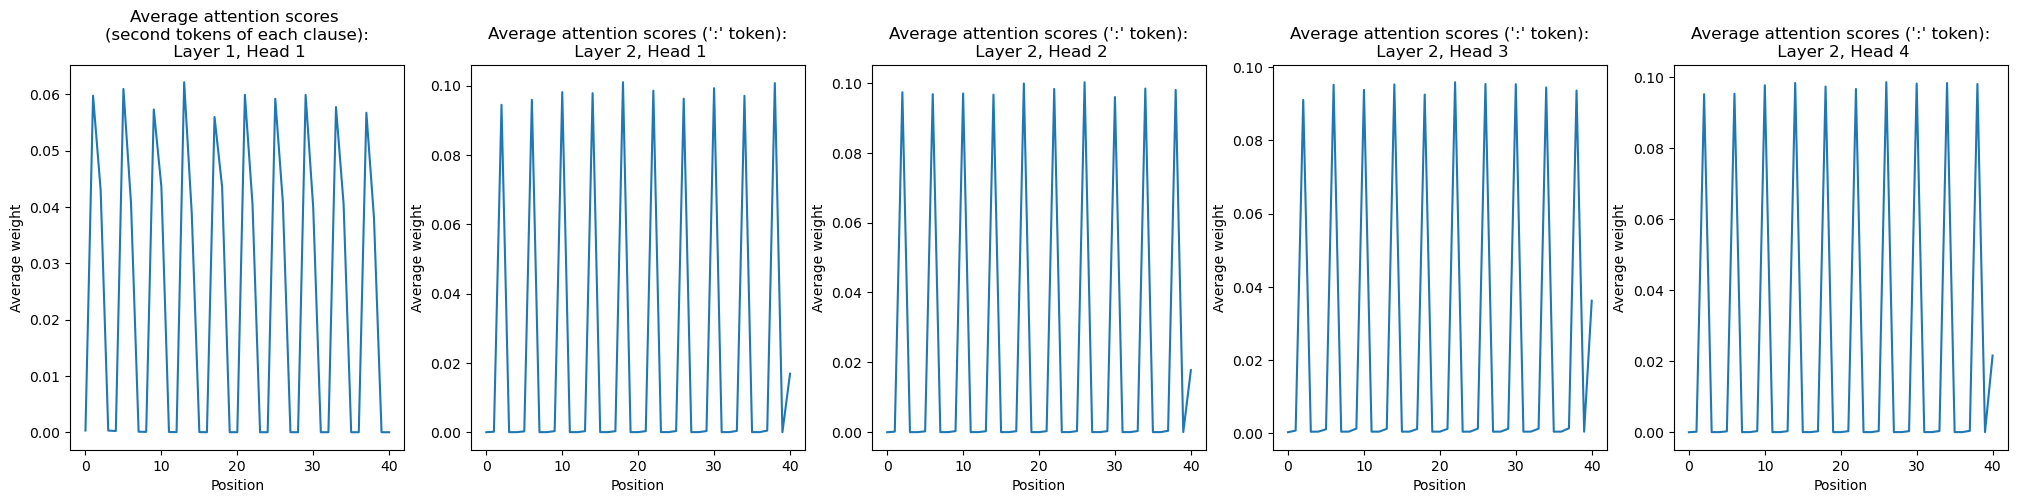

In [8]:
plot_average_test_attentions()
plt.savefig("img/test_attns.pdf", bbox_inches="tight")

## First Layer Attention

In [9]:
save_chart(
    (
    plot_score_df("tok", "tok") | plot_score_df("tok", "pos")
    ) & (
        plot_score_df("pos", "tok") | plot_score_df("pos", "pos")
    ), 
    "img/pre_softmax_first_layer.pdf"
)

alt.VConcatChart(...)

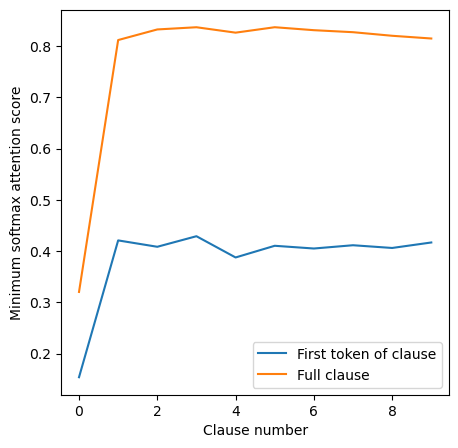

In [10]:
plot_extreme_first_layer_scores(path="img/min_weight.pdf")

In [11]:
df = get_avg_effect_df()

In [12]:
save_chart(
    plot_df(df, "Expected First-Layer Attention Score", softmax=True),
    "img/expected_post_softmax_first_layer.pdf",
)

alt.Chart(...)

In [13]:
plot_df(df, "Expected First-Layer Attention Score", softmax=False)

alt.Chart(...)

## ':' token

If we inspect the four relevant attention patterns for the ":" token, we can see that it has little preference towards any given token or position; hence it will attend to past tokens roughly uniformly.

In [14]:
df = get_colon_token_first_layer_scores()

In [15]:
save_chart(
    alt.Chart(df, title="First-Layer Attention Scores (':' token)").mark_rect(width=20, height=20).encode(
        alt.Y("Token", title="Source Token"),
        alt.X("Position:N", title="Source Token Position"),
        alt.Color("Score"),
    ),
    "img/attn_colon_first_layer.png",
)

alt.Chart(...)

The output attention patterns is near uniform

In [16]:
np.exp(df.Score.min())/(40*np.exp(df.Score.max()) + np.exp(df.Score.min()))

0.020887970554312938

In [17]:
1/41

0.024390243902439025

In [18]:
np.exp(df.Score.max())/(40*np.exp(df.Score.min()) + np.exp(df.Score.max()))

0.028462670764164113

In [19]:
QK = first_layer_attn_circuits().QK
def max_to_min(t):
    return t.max() - t.min()

In [20]:
max_to_min(QK["dst_pos_src_pos"][-1])

tensor(0.6608, device='cuda:0', grad_fn=<SubBackward0>)

In [21]:
max_to_min(QK["dst_pos_src_tok"][-1])

tensor(0.2608, device='cuda:0', grad_fn=<SubBackward0>)

In [22]:
max_to_min(QK["dst_tok_src_pos"][token_mappings[":"]])

tensor(0.6575, device='cuda:0', grad_fn=<SubBackward0>)

In [23]:
max_to_min(QK["dst_tok_src_tok"][token_mappings[":"]])

tensor(0.2595, device='cuda:0', grad_fn=<SubBackward0>)

# Check Conditions

Mechanisitic derivability is argued in the paper, distributional equivalence makes sense via the full model only, so will be checked at the end.

## Prefix Equivalence 

In [24]:
get_prefix_equivalence_eps(0, return_match_rate=True)

{'epsilon (confidence 0.95)': 3.744548424300387e-05, 'disagreement rate': 0.0}

We consider clause $x \lor y$ and clause $y \lor x$ identical in the abstract model.

In this case, we have perfect matching.

In [25]:
from interpretation import Clause

class ClauseOrdered:
    def __init__(self, clause):
        self.left = clause.left
        self.right = clause.right
        
    def to_var_list(self):
        return [self.left, self.right]
    
    def __eq__(self, other):
        return self.to_var_list() == other.to_var_list()

def to_ordered(clauses):
    return np.array([
        [ClauseOrdered(cj) for cj in rowi]
        for rowi in clauses
    ])

In [26]:
lhs = compose(to_ordered, get_equivalence_model_lhs(0))
rhs = compose(to_ordered, get_prefix_equivalence_model_rhs(0))

In [27]:
get_epsilon(lhs, rhs)

0.8492538892089277

Note that if we insist upon matching order results are much worse. However, this isn't reasonable as the abstract model does not distinguish at all between mirror-image clauses and the original model is affected very little; we can observe that this is the case by considering compositional faithfulness.

## Component Equivalence

As this is the first layer, the property is the same as the above.

## Prefix Replaceability

In [28]:
get_prefix_replaceability_eps(0)

0.04180386184648288

Substituting the first layer with the abstract first layer, which enforces that the first layer's action is purely to parse clauses as in our interpretation (and removes any effects from attention to parentheses or to previous clauses as well as any token-frequency effects from variation in the embedding of ':') has little impact on final classification.

## Component Replaceability

As this is the first layer, the property is the same as the above.

# Layer 2

## Attentions

In [29]:
attn = model.blocks[1].attn
W_Q = attn.W_Q
W_K = attn.W_K
W_V = attn.W_V
W_O = attn.W_O
n_heads = W_Q.shape[0]

W_E = model.embed.W_E
W_pos = model.pos_embed.W_pos

In [30]:
queries = torch.einsum("d,ihd->ih", colon_embed, W_Q)

In [31]:
def plot_attentions(exp=False):
    attns = []
    variables = list(concat([f"x{i}", f"Not(x{i})"] for i in range(config.nvars)))

    for l in variables:
        for r in variables:
            for clause_id in range(config.nclauses):
                attn_dict = {
                    "left": l,
                    "right": r,
                    "clause_id": clause_id,
                }
                
                embed = layer_1_clause_map[(token_mappings[l], token_mappings[r])]
                scores = torch.einsum("d, ihd, ih->i", embed, W_K, queries)
                if exp:
                    scores = scores.exp()
                
                for h in range(n_heads):
                    attn_dict[f"score_head_{h}"] = scores[h].detach().cpu().item()

                attns.append(attn_dict)
                
    df = pd.DataFrame.from_records(attns)
    
    return alt.Chart(df).mark_rect(width=20, height=20).encode(
        alt.X("left:N", title="First token of clause"),
        alt.Y("right:N", title="Second token of clause"),
        alt.Color("value:Q", title="Attention score"),
        alt.Column("key:N"),
    ).properties(
        width=300,
        height=300
    ).transform_fold(
        [f"score_head_{i}" for i in range(W_Q.shape[0])]
    )

In [32]:
save_chart(
    plot_attentions(),
    "img/second_layer_attns.pdf",
)

alt.Chart(...)

## Validating the effect of the MLP

In [33]:
model_no_mlp = load_model(config)

In [34]:
class Noop(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

In [35]:
model_no_mlp.blocks[1].mlp = Noop()

In [36]:
diffs = output_diffs(model_no_mlp, test)
diffs.float().mean()

tensor(0.4973, device='cuda:0')

In [37]:
model_no_attention_residual = load_model(config)

In [38]:
class TransformerBlockNoAttnResidual(nn.Module):
    def __init__(self, block, model):
        super().__init__()
        self.model = model
        self.attn = block.attn
        self.mlp = block.mlp
        
        self.hook_attn_out = HookPoint()
        self.hook_mlp_out = HookPoint()
        self.hook_resid_pre = HookPoint()
        self.hook_resid_mid = HookPoint()
        self.hook_resid_post = HookPoint()
    
    def forward(self, x):
        x = self.hook_resid_mid(x + self.hook_attn_out(self.attn((self.hook_resid_pre(x)))))
        # removes residual connection here
        x = self.hook_resid_post(self.hook_mlp_out(self.mlp((x))))
        return x

In [39]:
block = model_no_attention_residual.blocks[1]
model_no_attention_residual.blocks[1] = TransformerBlockNoAttnResidual(block, model_no_attention_residual)

In [40]:
diffs = output_diffs(model_no_attention_residual, test)
diffs.float().mean()

tensor(0.1223, device='cuda:0')

First, note that the UNSAT unembedding vector is nearly exactly the negative of the one for SAT.

In [41]:
W_U = model.unembed.W_U

In [42]:
torch.linalg.norm(W_U[:, token_mappings['u']] + W_U[:, token_mappings['s']])

tensor(6.2010e-06, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

Without the MLP, the model's prediction becomes essentially random. The residual connection from attention *is* necessary, however, its effect is always to predict UNSAT. Hence, the logic to predict SAT *must* flow through the MLP.

In [43]:
actual_logits = get_all_intermediates(test, "blocks.1.hook_resid_post")[:,-1].to(device) @ W_U
actual_logits.max(dim=0).values

tensor([-12.6954, -12.6954, -12.6954, -12.6954, -12.6954, -12.6954, -12.6954,
        -12.6954, -12.6954, -12.6954, -12.6954, -12.6954, -12.6954, 104.9941,
          3.6553, -12.6954], device='cuda:0', grad_fn=<MaxBackward0>)

In [44]:
sat_unsat_max = actual_logits[:, [token_mappings['u'], token_mappings['s']]].max(dim=1).values 
sat_unsat_max.min()

tensor(0.0015, device='cuda:0', grad_fn=<MinBackward1>)

In [45]:
actual_attn_out = get_all_intermediates(test, "blocks.1.hook_attn_out")
attn_residual_sat_effect = actual_attn_out[:,-1].to(device) @ W_U[:, token_mappings['s']]

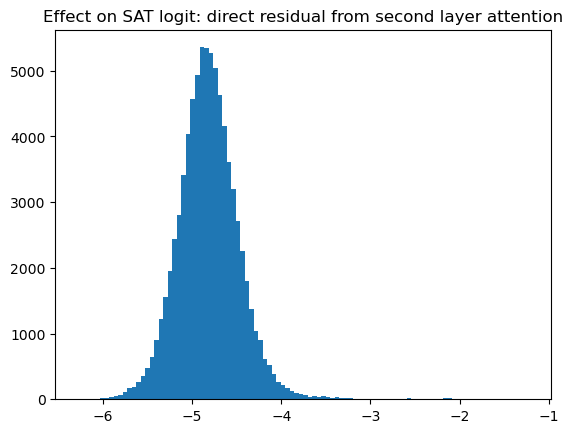

In [46]:
plt.figure()
plt.title("Effect on SAT logit: direct residual from second layer attention")
plt.hist(attn_residual_sat_effect.detach().cpu(), bins=100)
plt.savefig("img/second_layer_attn_residual.pdf")

Replacing with mean:

In [47]:
mean_attn_out = actual_attn_out.mean(dim=0, keepdim=True).to(device)

class TransformerBlockMeanAttnResidual(nn.Module):
    def __init__(self, block, model):
        super().__init__()
        self.model = model
        self.attn = block.attn
        self.mlp = block.mlp
        
        self.hook_attn_out = HookPoint()
        self.hook_mlp_out = HookPoint()
        self.hook_resid_pre = HookPoint()
        self.hook_resid_mid = HookPoint()
        self.hook_resid_post = HookPoint()
    
    def forward(self, x):
        x = self.hook_resid_mid(x + self.hook_attn_out(self.attn((self.hook_resid_pre(x)))))
        mean_x = mean_attn_out
        x = self.hook_resid_post(mean_x + self.hook_mlp_out(self.mlp((x))))
        return x

In [48]:
model_mean_attn_residual = load_model(config)
block = model_mean_attn_residual.blocks[1]
model_mean_attn_residual.blocks[1] = TransformerBlockMeanAttnResidual(block, model_mean_attn_residual)

In [49]:
diffs = output_diffs(model_mean_attn_residual, test)
diffs.float().mean()

tensor(0.0433, device='cuda:0')

## Sparsity in the hidden neurons

In [50]:
W_out = model.blocks[1].mlp.W_out
W_U = model.unembed.W_U
MLP_out = torch.einsum('et, em -> tm', W_U, W_out)[token_mappings['s']]
MLP_max_effect = torch.Tensor(activation_scores[train_idx].max(axis=0)).to(config.device) * MLP_out.to(config.device)

In [51]:
sat_coeffs = MLP_out[units_for_sat]

In [52]:
units_for_sat = (MLP_max_effect > 0.1).nonzero().flatten()
sat_coeffs = MLP_out[units_for_sat]

units_for_sat

tensor([ 10,  29,  36,  41,  48,  55,  77,  81,  96, 150, 185, 189, 195, 201,
        224, 231, 245, 261, 291, 304, 317, 326, 334, 374, 380, 411, 416, 435,
        450, 482, 490, 492, 495, 499], device='cuda:0')

In [53]:
relevant_ids = torch.zeros(MLP_out.shape[0], dtype=torch.bool)
relevant_ids[units_for_sat.cpu()] = True
non_relevant_ids = ~relevant_ids

In [54]:
MLP_out.abs()[units_for_sat].min()

tensor(2.9063, device='cuda:0', grad_fn=<MinBackward1>)

In [55]:
highest_non_evaluating_id = MLP_out.abs()[non_relevant_ids].argmax()
highest_non_evaluating_id = non_relevant_ids.nonzero()[highest_non_evaluating_id, 0]
highest_non_evaluating = MLP_out.abs()[highest_non_evaluating_id]
non_relevant_ids[highest_non_evaluating_id] = False
highest_remaining = MLP_out.abs()[non_relevant_ids].max()
highest_non_evaluating, MLP_max_effect[highest_non_evaluating_id], highest_remaining

(tensor(0.1273, device='cuda:0', grad_fn=<SelectBackward0>),
 tensor(0.0035, device='cuda:0', grad_fn=<SelectBackward0>),
 tensor(5.8303e-12, device='cuda:0', grad_fn=<MaxBackward1>))

The largest coefficient of a non-evaluating neuron is below 0.13 (and never affects the SAT logit), and all others have magnitude < $10^{-11}$. All evaluating neurons have coefficients above 2.9.

In [56]:
MLP_out = MLP_out.detach().cpu().numpy()

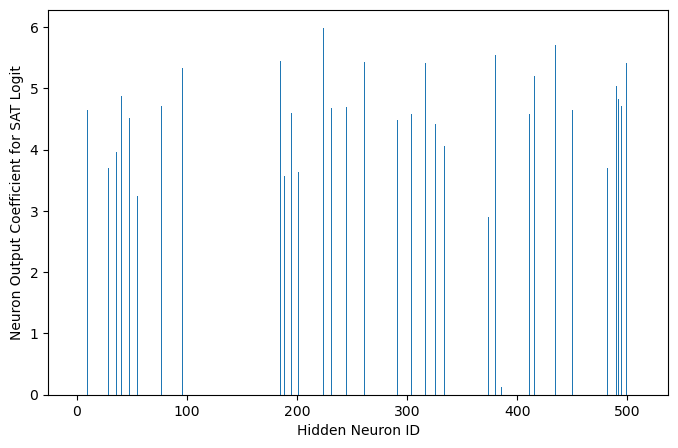

In [57]:
plt.figure(figsize=(8,5))
plt.bar(np.arange(MLP_out.shape[0]), MLP_out)
plt.xlabel("Hidden Neuron ID")
plt.ylabel("Neuron Output Coefficient for SAT Logit")
plt.savefig("img/sparse_hidden.pdf", bbox_inches="tight");

## Identifying Evaluation Behavior

In [58]:
activations_scaled  = activation_scores * MLP_out

In [59]:
train_activation_scores = activation_scores[train_idx]
test_activation_scores = activation_scores[test_idx]
train_activations_scaled = activations_scaled[train_idx]
test_activations_scaled = activations_scaled[test_idx]

truth_tables_train = all_truth_tables[train_idx]
truth_tables_test = all_truth_tables[test_idx]

x = all_data[train_idx]
x_test = all_data[test_idx]
y = x[:,-1] == token_mappings['s']
y_test = x_test[:,-1] == token_mappings['s']

If we take activation and the scaling factor from the second layer and unembedding matrices into account, what are the average effects on the SAT logit?

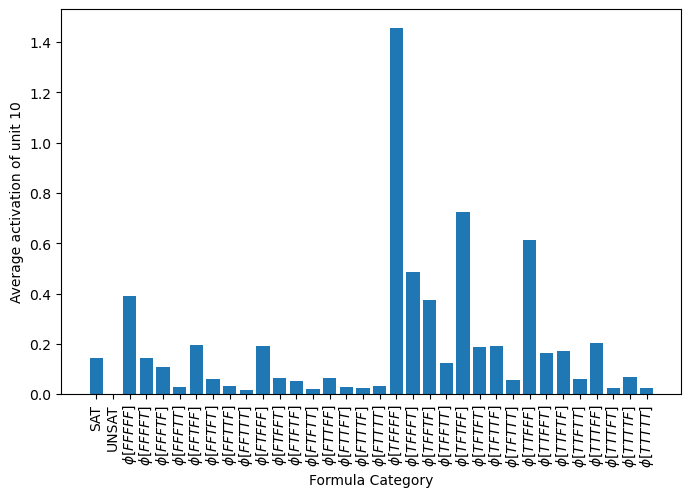

In [60]:
unit = 10
scores = unit_scores[unit]
plt.figure(figsize=(8,5))
to_labels = compose(list, map(lambda k: f"$\\phi {k[1:]}$" if "SAT" not in k else k))
keys = sorted(scores.keys())
values = [scores[k] for k in keys]
plt.xticks(rotation=90)
plt.xlabel("Formula Category")
plt.ylabel(f"Average activation of unit {unit}")
plt.bar(to_labels(keys), values)
plt.savefig("img/unit_10.pdf", bbox_inches="tight");

Across all heads, the total effect of satisfiability with any assignment to the variables is high.

In [61]:
total_impacts = defaultdict(float)

for v in unit_impacts.values():
    for k, v_p in v.items():
        total_impacts[k] += v_p

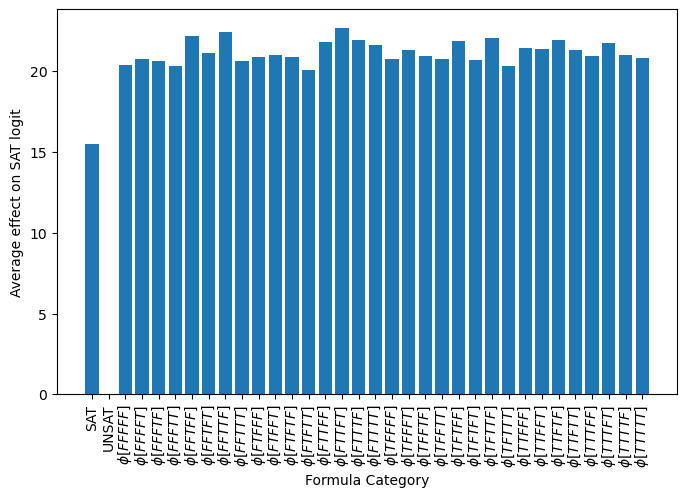

In [62]:
plt.figure(figsize=(8,5))
to_labels = compose(list, map(lambda k: f"$\\phi {k[1:]}$" if "SAT" not in k else k))
keys = sorted(scores.keys())
values = [total_impacts[k] for k in keys]
plt.xticks(rotation=90)
plt.xlabel("Formula Category")
plt.ylabel("Average effect on SAT logit")
plt.bar(to_labels(keys), values)
plt.savefig("img/net_effect_sat_logit.pdf", bbox_inches="tight");

In [63]:
avg_effects = {}
max_effects_set = set()
max_eval_effects = defaultdict(float)

trim = 0.1
large_cutoff = 1

for k, v in unit_impacts.items():
    argmax = max(v, key=v.get)
    maximum = v[argmax]

    for k1, v1 in v.items():
        max_eval_effects[k1] = max(max_eval_effects[k1], v1)
    
    if maximum < trim:
        print(f"Max eval effect on {k} is {maximum}")
    else:
        avg_effects[k] = (argmax, maximum)
        max_effects_set.add(argmax)

In [64]:
max(max_eval_effects[k] for k in feature_names_truth_tables)

7.113730380885626

In [65]:
min(max_eval_effects[k] for k in feature_names_truth_tables)

2.903723396454054

In [66]:
del max_eval_effects["SAT"]
min(max_eval_effects.values())

2.903723396454054

Now, we can begin to see clearly how the model is predicting SAT: it appears to be using the brute-force approach which evaluates the formula for each possible assignment to the variables.

However, the average behavior doesn't tell the whole story:

In [67]:
df = pd.DataFrame(
    data=np.hstack((truth_tables_train, train_activation_scores[:, units_for_sat.cpu()], y[:, np.newaxis])),
    columns=feature_names_truth_tables + [f"SCORE({u})" for u in units_for_sat] + ["SAT"]
)

In [68]:
{
    k: df[df[k] == 1][[f"SCORE({u})" for u in units_for_sat]].min().max()
    for k in feature_names_truth_tables
}

{'𝜙[FFFFF]': 0.0,
 '𝜙[FFFFT]': 0.0013634832575917244,
 '𝜙[FFFTF]': 0.0,
 '𝜙[FFFTT]': 0.08942322432994843,
 '𝜙[FFTFF]': 0.0,
 '𝜙[FFTFT]': 0.0,
 '𝜙[FFTTF]': 0.0,
 '𝜙[FFTTT]': 0.0,
 '𝜙[FTFFF]': 0.0,
 '𝜙[FTFFT]': 0.0,
 '𝜙[FTFTF]': 0.0,
 '𝜙[FTFTT]': 0.0,
 '𝜙[FTTFF]': 0.0,
 '𝜙[FTTFT]': 0.0,
 '𝜙[FTTTF]': 0.0,
 '𝜙[FTTTT]': 0.0,
 '𝜙[TFFFF]': 0.0,
 '𝜙[TFFFT]': 0.0,
 '𝜙[TFFTF]': 0.0,
 '𝜙[TFFTT]': 0.0,
 '𝜙[TFTFF]': 0.0,
 '𝜙[TFTFT]': 0.0,
 '𝜙[TFTTF]': 0.0,
 '𝜙[TFTTT]': 0.0,
 '𝜙[TTFFF]': 0.0,
 '𝜙[TTFFT]': 0.0,
 '𝜙[TTFTF]': 0.0,
 '𝜙[TTFTT]': 0.0,
 '𝜙[TTTFF]': 0.0,
 '𝜙[TTTFT]': 0.0,
 '𝜙[TTTTF]': 0.0,
 '𝜙[TTTTT]': 0.0}

Even nodes that have large effects from a particular assignment may fail to activate; their behavior is more complex than simple detection for a single assignment.

Let's see if decision trees can capture that behavior.

# Decision Trees

In [69]:
truth_tables_train = all_truth_tables[train_idx]
truth_tables_test = all_truth_tables[test_idx]

In [70]:
def models(i, max_leaf_nodes=None):
    m = sklearn.tree.DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes)
    m.fit(truth_tables_train, activation_scores[train_idx,i] >= config.activation_threshold)
    return prune(m)

node_models_max_2_leaf = list(parmap_unbatched(partial(models, max_leaf_nodes=2), range(MLP_out.shape[0])))
node_models_max_4_leaf = list(parmap_unbatched(partial(models, max_leaf_nodes=4), range(MLP_out.shape[0])))
node_models_max_16_leaf = list(parmap_unbatched(partial(models, max_leaf_nodes=16), range(MLP_out.shape[0])))
node_models_full = list(parmap_unbatched(partial(models, max_leaf_nodes=None), range(MLP_out.shape[0])))

## Models with increasing size

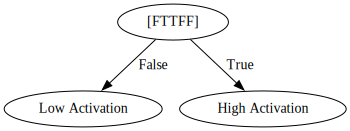

In [71]:
render_graphviz(node_models_max_2_leaf[29], path="img/unit_29_2_leaf.pdf")

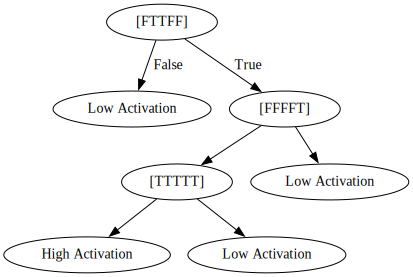

In [72]:
render_graphviz(node_models_max_4_leaf[29], path="img/unit_29_4_leaf.pdf")

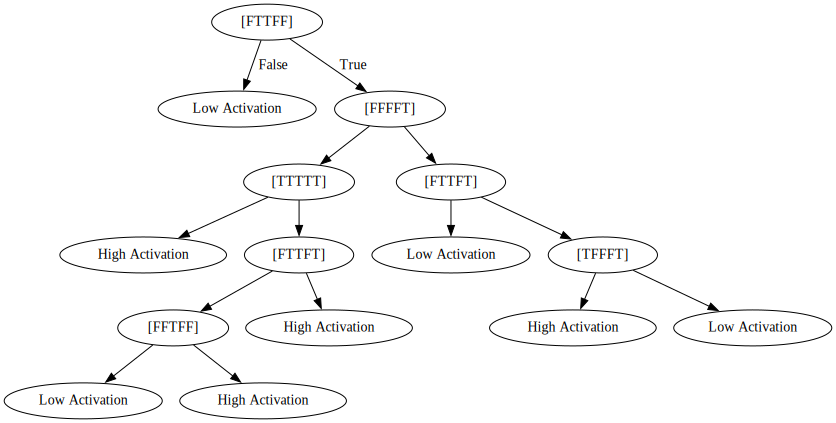

In [73]:
render_graphviz(node_models_max_16_leaf[29], path="img/unit_29_16_leaf.pdf")

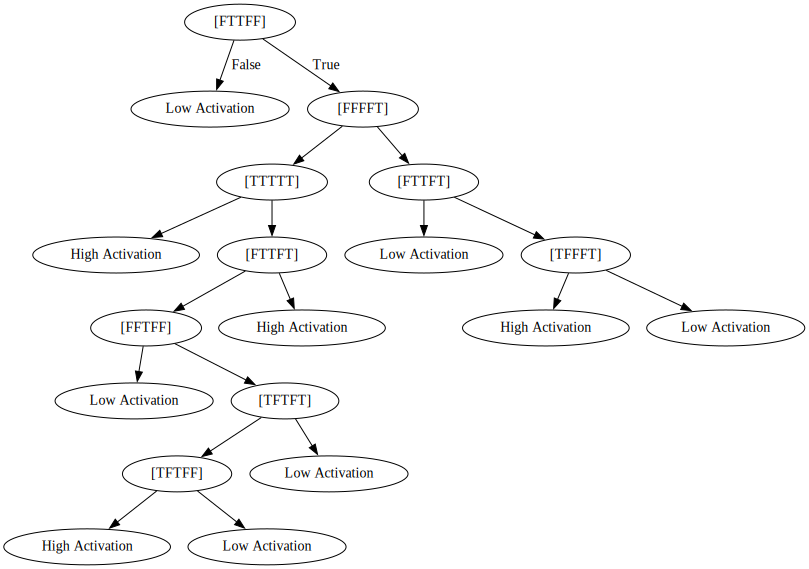

In [74]:
render_graphviz(node_models_full[29], path="img/unit_29_unlimited_leaf.pdf")

## Check whether all assignments are evaluated

In [75]:
def get_evaluated_assignments(node_models=node_models, relevant_units=units_for_sat):
    matched_feature_ids = set()
    
    for i in relevant_units.cpu().numpy():
        m = node_models[i]
        tree = m.tree_
        for fid in tree.feature:
            if fid >= 0:
                matched_feature_ids.add(fid)

    return matched_feature_ids

In [76]:
set(range(2**config.nvars)) - get_evaluated_assignments(node_models_max_2_leaf)

{8, 20, 29}

In [77]:
set(range(2**config.nvars)) - get_evaluated_assignments(node_models)

set()

## Evaluating Predictive Power

In [78]:
def f1(tup):
    i, m = tup
    
    return metrics.f1_score(activation_scores[test_idx,i] >= config.activation_threshold, m.predict(truth_tables_test), zero_division=1)

truth_table_f1_small = np.array(parmap_unbatched(f1, enumerate(node_models_max_2_leaf)))
truth_table_f1_med = np.array(parmap_unbatched(f1, enumerate(node_models_max_4_leaf)))
truth_table_f1_full = np.array(parmap_unbatched(f1, enumerate(node_models_full)))

In [79]:
MLP_max_effect = MLP_max_effect.detach().cpu().numpy()

In [80]:
relevant_ids = torch.zeros(MLP_out.shape[0], dtype=torch.bool)
relevant_ids[units_for_sat.cpu()] = True
non_relevant_ids = ~relevant_ids

max_effect_relevant = MLP_max_effect[relevant_ids]
max_effect_non_relevant = MLP_max_effect[non_relevant_ids]

f1s_small_relevant = truth_table_f1_small[relevant_ids]
f1s_small_non_relevant = truth_table_f1_small[non_relevant_ids]

f1s_relevant_med = truth_table_f1_med[relevant_ids]
f1s_non_relevant_med = truth_table_f1_med[non_relevant_ids]

f1s_full_relevant = truth_table_f1_full[relevant_ids]
f1s_full_non_relevant = truth_table_f1_full[non_relevant_ids]

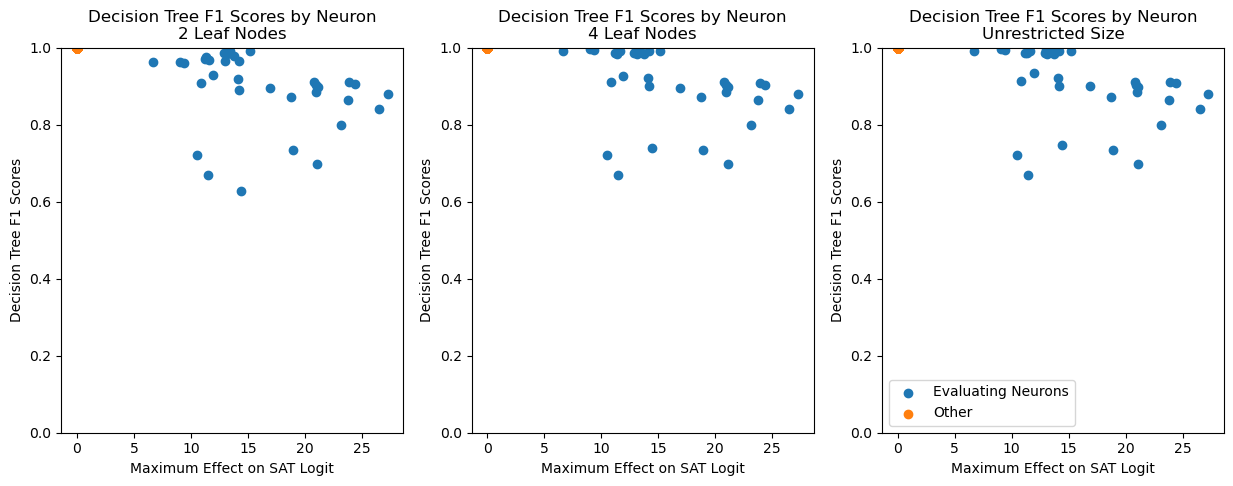

In [81]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].scatter(max_effect_relevant, f1s_small_relevant, label="Evaluating Neurons")
ax[0].scatter(max_effect_non_relevant, f1s_small_non_relevant, label="Other")
ax[0].set_title("Decision Tree F1 Scores by Neuron\n2 Leaf Nodes")

ax[1].scatter(max_effect_relevant, f1s_relevant_med, label="Evaluating Neurons")
ax[1].scatter(max_effect_non_relevant, f1s_non_relevant_med, label="Other")
ax[1].set_title("Decision Tree F1 Scores by Neuron\n4 Leaf Nodes")

ax[2].scatter(max_effect_relevant, f1s_full_relevant, label="Evaluating Neurons")
ax[2].scatter(max_effect_non_relevant, f1s_full_non_relevant, label="Other")
ax[2].set_title("Decision Tree F1 Scores by Neuron\nUnrestricted Size")

for i in range(3):
    ax[i].set_xlabel("Maximum Effect on SAT Logit")
    ax[i].set_ylabel("Decision Tree F1 Scores")
    ax[i].set_ylim([0,1])

plt.legend()
plt.savefig("img/f1_dtrees.pdf")

## Checking the Axioms

We treat the abstract state as a Boolean version of the output of the neuron (i.e. is it above a cutoff); as the second layer + unembed's behavior means that each neuron directly promotes SAT, the model essentially performs an OR on these abstract outputs.

## Prefix Equivalence 

In [82]:
get_prefix_equivalence_eps(1)

0.18215883436961855

In [83]:
epsilon = "\U000003F5"

def allowable_deviation_graph(base_fn, deviations=[0,1,2,4], save_path=None, title=None):
    p95_eps = [base_fn(allowable_deviation=d) for d in deviations]
    plt.plot(deviations, p95_eps)
    plt.xlabel("Tolerated Errors in Neuron Models")
    plt.ylabel(f"P95 {epsilon}")

    if title is not None:
        plt.title(title)

    if save_path is not None:
        plt.savefig(save_path)

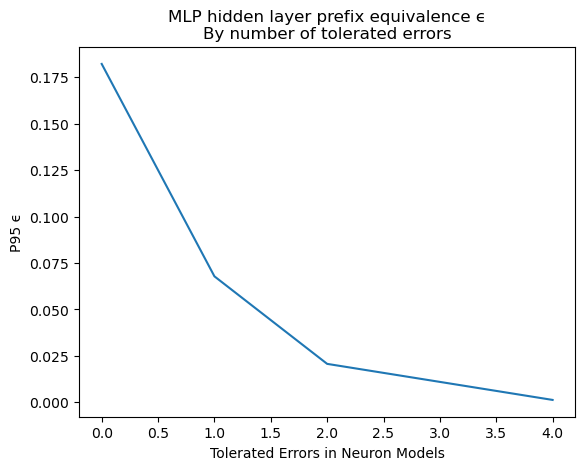

In [84]:
allowable_deviation_graph(partial(get_prefix_equivalence_eps, 1), title=f"MLP hidden layer prefix equivalence {epsilon}\nBy number of tolerated errors", save_path="img/prefix_equivalence_tolerate_errors.pdf")

## Component Equivalence

In [85]:
get_component_equivalence_eps(1)

0.18215883436961855

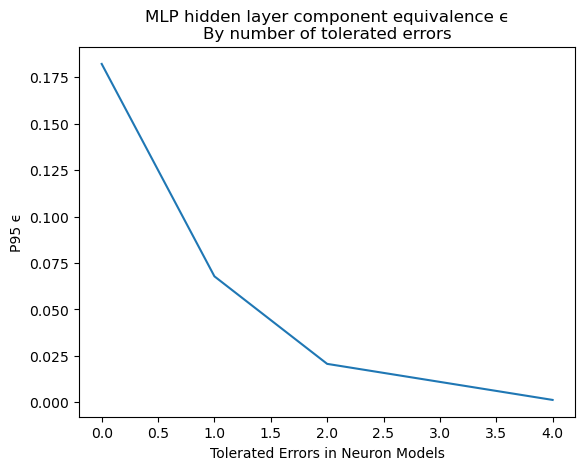

In [86]:
allowable_deviation_graph(partial(get_component_equivalence_eps, 1), title=f"MLP hidden layer component equivalence {epsilon}\nBy number of tolerated errors", save_path="img/compoennt_equivalence_tolerate_errors.pdf")

If we substitute back 2 we get very strong results

## Prefix Replaceability

In [87]:
get_prefix_replaceability_eps(1)

0.012832116070376487

## Component Replaceability


In [88]:
get_component_replaceability_eps(1)

0.012832116070376487

If we substitute back the cutoff of 0.5, we get much worse results:

In [89]:
config_no_increase = Config(
    load_model_path="models/layers_2_heads_1_4_1M/900.pth",
    data_path="data/cnf_tokens_1M.npy",
    data_path_interpretation = "data/cnf_tokens_100K.npy",
    base_cache_path="cache",
    num_heads=[1,4],
    batch_size=100,
    device=device,
    data_parallel=False,
    high_activation=config.activation_threshold,
)

interp_tools_no_increase = tools(config_no_increase, model=model)

SAT instances in fixed len data:  100001
UNSAT instances in fixed len data:  100000
SAT instances in train:  60000
UNSAT instances in train:  60000
SAT instances in test:  40001
UNSAT instances in test:  40000


## Prefix Replaceability

In [90]:
interp_tools_no_increase.get_prefix_replaceability_eps(1)

0.24900366565232157

## Component Replaceability


In [91]:
interp_tools_no_increase.get_component_replaceability_eps(1)

0.24900366565232157


# Output Layer

We have, as seen above, very simple behavior in the concrete model: the direct effect of the residual from attention is to promote UNSAT, while the SAT logit is increased directly by each of the evaluating neurons. As all evaluating neurons have large coefficients of around 3-6 by which they increase SAT, a large activation on any neuron will result in a SAT classification (hence, the output layer of the MLP and the unembedding implicitly act as an OR operation).

## Prefix Equivalence 

In [92]:
get_prefix_equivalence_eps(2)

0.012832116070376487

## Component Equivalence

In [93]:
get_component_equivalence_eps(2)

0.004334649183158956

## Prefix Replaceability

In [94]:
get_prefix_replaceability_eps(2)

0.012832116070376487

## Component Replaceability


In [95]:
get_component_replaceability_eps(2)

0.004334649183158956

# Disjunction-Only Model

In [96]:
units_for_sat = units_for_sat.detach().cpu()

In [97]:
unit_evaluations_for_sat = {}
disjunction_models = {}

for unit in units_for_sat.numpy():
    scores = unit_scores[unit]
    evaluated = []
    disjunction_model = []
    for k, v in scores.items():
        if v > config.activation_threshold:
            evaluated.append(k)
            disjunction_model.append(feature_names_truth_tables_rev_map[k])

    unit_evaluations_for_sat[unit] = evaluated
    disjunction_models[unit] = np.array(disjunction_model)

In [98]:
unit_evaluations_for_sat

{10: ['𝜙[TFFFF]', '𝜙[TFTFF]', '𝜙[TTFFF]'],
 29: ['𝜙[FTTFF]'],
 36: ['𝜙[TTFFF]'],
 41: ['𝜙[FFFFF]', '𝜙[FTFFF]'],
 48: ['𝜙[FTFFF]', '𝜙[FTTFF]'],
 55: ['𝜙[TTTFF]', '𝜙[TTTFT]'],
 77: ['𝜙[FFTTF]', '𝜙[FFTTT]', '𝜙[FTTTT]'],
 81: ['𝜙[FTTTF]', '𝜙[FTTTT]'],
 96: ['𝜙[TFTTF]'],
 150: ['𝜙[FTFTF]'],
 185: ['𝜙[FFFTT]'],
 189: ['𝜙[FTTTT]'],
 195: ['𝜙[TFFTF]', '𝜙[TFTTF]', '𝜙[TTFTF]'],
 201: ['𝜙[TTFFT]'],
 224: ['𝜙[FFFFT]'],
 231: ['𝜙[FTFTT]', '𝜙[FTTTT]'],
 245: ['𝜙[FTFFF]', '𝜙[FTFFT]', '𝜙[FTTFT]'],
 261: ['𝜙[TTFTT]'],
 291: ['𝜙[TFTTF]', '𝜙[TFTTT]', '𝜙[TTTTT]'],
 304: ['𝜙[FFTTF]'],
 317: ['𝜙[TFFFT]'],
 326: ['𝜙[TTFTF]', '𝜙[TTTTF]', '𝜙[TTTTT]'],
 334: ['𝜙[FTTTF]'],
 374: ['𝜙[TTFTT]'],
 380: ['𝜙[TFFTT]'],
 411: ['𝜙[TTFFT]', '𝜙[TTTFT]'],
 416: ['𝜙[TFTFF]', '𝜙[TTTFF]'],
 435: ['𝜙[TTFTF]'],
 450: ['𝜙[FFTFF]', '𝜙[FFTFT]', '𝜙[FTTFT]'],
 482: ['𝜙[TTTTT]'],
 490: ['𝜙[FTTFT]'],
 492: ['𝜙[TFTFF]', '𝜙[TFTFT]', '𝜙[TTTFT]'],
 495: ['𝜙[FFFTF]'],
 499: ['𝜙[FFTFF]']}

We have full coverage of assignments (hence, if the model *actually* behaved in this way, it would predict SAT perfectly).

In [99]:
evaluated_assignments_disjunction_only = set().union(*(set(dm) for dm in disjunction_models.values()))

In [100]:
set(range(2**config.nvars)) - evaluated_assignments_disjunction_only

set()

In [101]:
def predict_disjunction_only_model(truth_table):
    # All non-evaluating units never have high activation
    prediction = np.zeros(MLP_out.shape[0], dtype=np.bool_)

    for unit, disjunction_model in disjunction_models.items(): 
        prediction[unit] = np.any(truth_table[disjunction_model])

    return prediction

In [102]:
disjunction_only_predictions = np.array(parmap(predict_disjunction_only_model, truth_tables_test))

In [103]:
def f1_disjunction_only_model(i):
    return metrics.f1_score(activation_scores[test_idx,i] >= config.activation_threshold, disjunction_only_predictions[:,i], zero_division=1)

disjunction_only_f1 = np.array(list(map(f1_disjunction_only_model, range(MLP_out.shape[0]))))

In [104]:
f1s_disjunction_only_relevant = disjunction_only_f1[relevant_ids]
f1s_disjunction_only_non_relevant = disjunction_only_f1[non_relevant_ids]

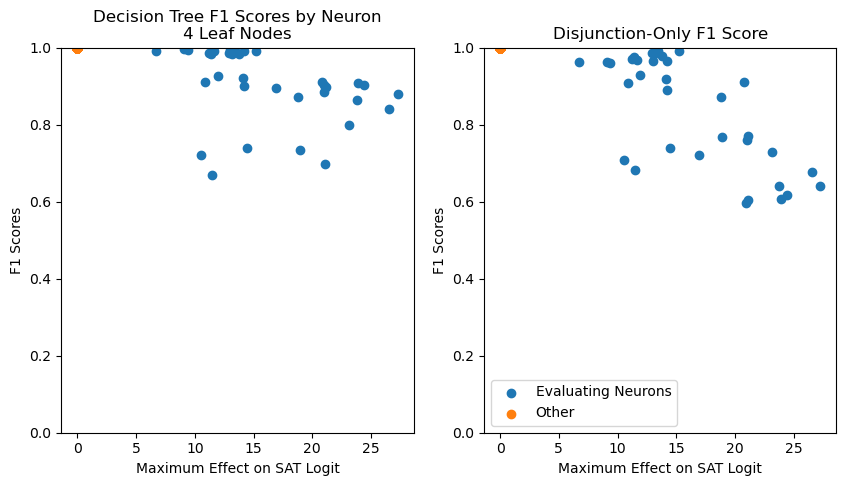

In [105]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(max_effect_relevant, f1s_relevant_med, label="Evaluating Neurons")
ax[0].scatter(max_effect_non_relevant, f1s_non_relevant_med, label="Other")
ax[0].set_title("Decision Tree F1 Scores by Neuron\n4 Leaf Nodes")

ax[1].scatter(max_effect_relevant, f1s_disjunction_only_relevant, label="Evaluating Neurons")
ax[1].scatter(max_effect_non_relevant, f1s_disjunction_only_non_relevant, label="Other")
ax[1].set_title("Disjunction-Only F1 Score")

for i in range(2):
    ax[i].set_xlabel("Maximum Effect on SAT Logit")
    ax[i].set_ylabel("F1 Scores")
    ax[i].set_ylim([0,1])

plt.legend()
plt.savefig("img/f1_disjunction_only.pdf")

In [106]:
from types import SimpleNamespace

def disjunction_only_node_model(i):
    if i not in units_for_sat:
        model =  lambda tts: np.zeros(tts.shape[0], dtype=np.bool_)
    else:
        disjunction_model = disjunction_models[i]
        def model(tts):
            return np.any(tts[:, disjunction_model], axis=-1)

    predictor = SimpleNamespace(predict=model)
    
    return predictor

disjunction_only_node_models = [disjunction_only_node_model(i) for i in range(MLP_out.shape[0])]

In [107]:
interp_tools_disjunction_only = tools(config, model=model, node_models=disjunction_only_node_models)

SAT instances in fixed len data:  100001
UNSAT instances in fixed len data:  100000
SAT instances in train:  60000
UNSAT instances in train:  60000
SAT instances in test:  40001
UNSAT instances in test:  40000


## Evaluating the Axioms

## MLP Hidden Layer

### Prefix Equivalence 

In [108]:
interp_tools_disjunction_only.get_prefix_equivalence_eps(1)

0.3093139963702074

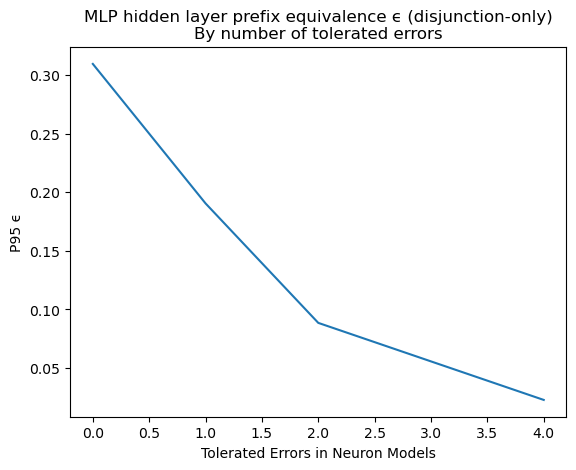

In [109]:
allowable_deviation_graph(partial(interp_tools_disjunction_only.get_prefix_equivalence_eps, 1), title=f"MLP hidden layer prefix equivalence {epsilon} (disjunction-only)\nBy number of tolerated errors", save_path="img/prefix_equivalence_tolerate_errors_disjunction_only.pdf")

### Component Equivalence

In [110]:
interp_tools_disjunction_only.get_component_equivalence_eps(1)

0.3093139963702074

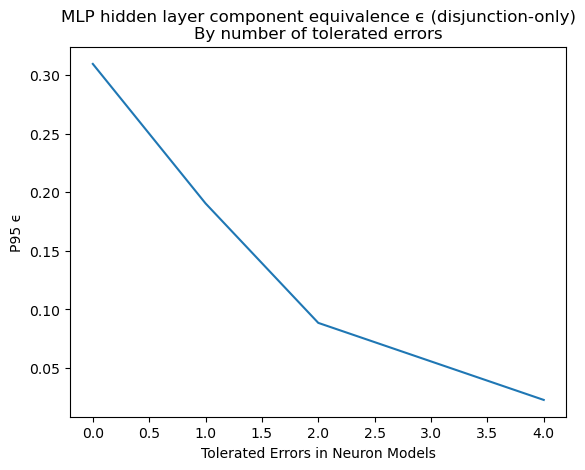

In [111]:
allowable_deviation_graph(partial(interp_tools_disjunction_only.get_component_equivalence_eps, 1), title=f"MLP hidden layer component equivalence {epsilon} (disjunction-only)\nBy number of tolerated errors", save_path="img/compoennt_equivalence_tolerate_errors_disjunction_only.pdf")

### Prefix Replaceability

In [112]:
interp_tools_disjunction_only.get_prefix_replaceability_eps(1)

0.0029029695601768823

### Component Replaceability


In [113]:
interp_tools_disjunction_only.get_component_replaceability_eps(1)

0.0029029695601768823

## No amplification step

In [114]:
interp_tools_no_increase_disjunction_only = tools(config_no_increase, model=model, node_models=disjunction_only_node_models)

SAT instances in fixed len data:  100001
UNSAT instances in fixed len data:  100000
SAT instances in train:  60000
UNSAT instances in train:  60000
SAT instances in test:  40001
UNSAT instances in test:  40000


In [115]:
interp_tools_no_increase_disjunction_only.get_prefix_replaceability_eps(1)

0.13490112778454566

In [116]:
interp_tools_no_increase_disjunction_only.get_component_replaceability_eps(1)

0.13490112778454566


## Output Layer


### Prefix Equivalence 

In [117]:
interp_tools_disjunction_only.get_prefix_equivalence_eps(2)

0.0029029695601768823

### Component Equivalence

In [118]:
interp_tools_disjunction_only.get_component_equivalence_eps(2)

0.004334649183158956

### Prefix Replaceability

In [119]:
interp_tools_disjunction_only.get_prefix_replaceability_eps(2)

0.0029029695601768823

### Component Replaceability


In [120]:
interp_tools_disjunction_only.get_component_replaceability_eps(2)

0.004334649183158956

# Evaluation Implementation

In [121]:
queries = output_token_query()
attns = []
for l in variables:
    for r in variables:
        for clause_id in range(config.nclauses):
            attn_dict = {
                "left": l,
                "right": r,
            }

            embed = layer_1_clause_map[(token_mappings[l], token_mappings[r])]
            scores = torch.einsum("d, ihd, ih->i", embed, W_K, queries)
            scores /= np.sqrt(model.blocks[1].attn.d_head)
                
            for h in range(n_heads):
                attn_dict[f"score_head_{h}"] = scores[h].detach().cpu().item()
                attn_dict[f"exp_score_head_{h}"] = torch.exp(scores[h]).detach().cpu().item()
                attn_dict[f"MLP_hidden_contributions_{h}"] = MLP_hidden_contributions(embed, model)[h, unit].detach().cpu().item()
                attn_dict[f"MLP_hidden_contributions_scaled_{h}"] = attn_dict[f"MLP_hidden_contributions_{h}"] * attn_dict[f"exp_score_head_{h}"]

            attns.append(attn_dict)

In [122]:
df = pd.DataFrame.from_records(attns)

In [123]:
violating_clauses = []
violating_vars = ["Not(x0)"] + [f"x{i}" for i in range(1,5)]

for l in variables:
    for r in variables:
        if l in violating_vars and r in violating_vars:
            violating_clauses.append((l, r))

In [124]:
remaining_clauses = list(set((l, r) for l in variables for r in variables) - set(violating_clauses))

In [125]:
clause_effect_dict = {}

for clause in violating_clauses:
    effects = {}
    for h in range(n_heads):
        i = df[(df.left == clause[0]) & (df.right == clause[1])].index[0]
        
        num = df.loc[i, f"MLP_hidden_contributions_scaled_{h}"]
        denom = df.loc[i, f"exp_score_head_{h}"]

        effects[f"head_{h}"] = {"num": num, "denom": denom}

    clause_effect_dict[clause] = effects

violating_nums = defaultdict(list)
violating_denoms = defaultdict(list)

for k, v in clause_effect_dict.items():
    for h, cs in v.items():
        violating_nums[h].append(cs["num"])
        violating_denoms[h].append(cs["denom"])

In [126]:
non_violating_clause_effect_dict = {}

for clause in remaining_clauses:
    effects = {}
    for h in range(n_heads):
        i = df[(df.left == clause[0]) & (df.right == clause[1])].index[0]
        
        num = df.loc[i, f"MLP_hidden_contributions_scaled_{h}"]
        denom = df.loc[i, f"exp_score_head_{h}"]

        effects[f"head_{h}"] = {"num": num, "denom": denom}

    non_violating_clause_effect_dict[clause] = effects

non_violating_nums = defaultdict(list)
non_violating_denoms = defaultdict(list)

for k, v in non_violating_clause_effect_dict.items():
    for h, cs in v.items():
        non_violating_nums[h].append(cs["num"])
        non_violating_denoms[h].append(cs["denom"])

In [127]:
def hists(df, bins=20, scale=alt.Undefined, rows=None, cols=[f"head_{i}" for i in range(n_heads)]):
    return alt.Chart(df).mark_bar().encode(
        *((alt.Row(rows),) if rows is not None else ()),
        alt.X("value:Q").bin(maxbins=bins),
        alt.Y("count()", scale=scale),
        alt.Column("key:N"),
    ).properties(
        width=300,
        height=300,
    ).transform_fold(
        cols
    )

In [128]:
save_chart(
    hists(pd.DataFrame.from_dict(violating_nums)).properties(
        title ="Coefficients for Numerators (Clauses Violating Condition)"
    ) & hists(pd.DataFrame.from_dict(non_violating_nums)).properties(
        title ="Coefficients for Numerators (Clauses Not Violating Condition)"
    ),
    "img/numerators_unit_10.pdf",
)

alt.VConcatChart(...)

In [129]:
save_chart(
    hists(pd.DataFrame.from_dict(violating_denoms)).properties(
        title ="Coefficients for Denominators (Clauses Violating Condition)"
    )  & hists(pd.DataFrame.from_dict(non_violating_denoms)).properties(
        title ="Coefficients for Denominators (Clauses Not Violating Condition)"
    ),
    "img/denominators_unit_10.pdf",
)

alt.VConcatChart(...)